# MSA

The MSA module of MIToS has utilities for working with Multiple Sequence Alignments of protein Sequences (MSA).

## Features

- [**Read**](#Reading-MSA-files) and [**write**](#Writing-MSA-files) MSAs in `Stockholm`, `FASTA` or `Raw` format
- Handle [**MSA annotations**](#MSA-Annotations)
- [**Edit the MSA**](#Editing-your-MSA), e.g. delete columns or sequences, change sequence order, shuffling...
- [**Keep track of positions**](#Column-and-sequence-mappings) and annotations after modifications on the MSA
- [**Describe an MSA**](#Describing-your-MSA), e.g. mean percent identity, sequence coverage, gap percentage...
- [**Sequence clustering**](#Sequence-clustering) with Hobohm I 

In [1]:
using MIToS.MSA

## Contents

- [MSA IO](#MSA-IO)
    - [Reading MSA files](#Reading-MSA-files)
    - [Writing MSA files](#Writing-MSA-files)
- [MSA Annotations](#MSA-Annotations)
- [Editing your MSA](#Editing-your-MSA)
    - [Example: Deleting sequences](#Example:-Deleting-sequences)
    - [Example: Exporting a MSA for freecontact (part I)](Example:-Exporting-a-MSA-for-freecontact-(part-I))
- [Column and sequence mappings](#Column-and-sequence-mappings)
    - [Example: Exporting a MSA for freecontact (part II)](#Example:-Exporting-a-MSA-for-freecontact-(part-II))
- [Get sequences from a MSA](#Get-sequences-from-a-MSA)
- [Describing your MSA](#Describing-your-MSA)
    - [Example: Plotting gap percentage per column and coverage per sequence](#Example:-Plotting-gap-percentage-per-column-and-coverage-per-sequence)
    - [Example: Filter sequences per coverage and columns per gap fraction](#Example:-Filter-sequences-per-coverage-and-columns-per-gap-fraction)
    - [Example: Plotting the percentage of identity between sequences](#Example:-Plotting-the-percentage-of-identity-between-sequences)
- [Sequence clustering](#Sequence-clustering)
    - [Example: Reducing redundancy of a MSA](#Example:-Reducing-redundancy-of-a-MSA)

In [2]:
# Truncate IJulia outputs at:
ENV["LINES"]   = 15 
ENV["COLUMNS"] = 60;

<a href="#"><i class="fa fa-arrow-up"></i></a>

## MSA IO

### Reading MSA files

The main function for reading MSA files in MIToS is `read` and it is defined in the `Utils` module. This function takes a filename/path as a first argument followed by other arguments. It opens the file and uses the arguments to call the `parse` function. `read` decides how to open the file, using the prefixes and suffixes of the file name, while `parse` does the actual parsing of the file. You can `read` **gzipped files** if they have the `.gz` extension and also urls pointing to a **web file**.  
The second argument of `read` and `parse` is the file `Format`. The supported MSA formats at the moment are `Stockholm`, `FASTA` and `Raw`.  
For example, reading with MIToS the full Stockholm MSA of the family PF07388 using the Pfam RESTful interface will be:

In [3]:
read("http://pfam.xfam.org/family/PF07388/alignment/full", Stockholm)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4168  100  4168    0     0   2073      0  0:00:02  0:00:02 --:--:--  2074


4x458 MIToS.MSA.AnnotatedMultipleSequenceAlignment:
 -  -  -  -  -  -  -  -  -  …  -  -  -  -  -  -  -  -  -
 M  L  K  K  I  K  K  A  L     -  -  -  -  -  -  -  -  -
 -  -  K  K  L  S  G  L  M     K  Y  R  I  K  Y  L  Q  L
 -  -  -  -  -  -  -  -  -     -  -  -  -  -  -  -  -  -

The third (and optional) argument of `read` and `parse` is the output MSA type:  
  
<p>
    <dl>
    
        <dt><code>Matrix{Residue}</code></dt>
        <dd>It is the default output format when reading a <code>Raw</code> file. It contains the aligned sequences.</dd>
        
        <dt><code>MultipleSequenceAlignment</code></dt>
        <dd>It contains the aligned sequences and their names/identifiers.</dd>
        
        <dt><code>AnnotatedMultipleSequenceAlignment</code></dt>
        <dd>Is the richest MSA format of MIToS and the default option when the input was a <code>FASTA</code> or <code>Stockholm</code> file. It includes the aligned sequences, their names and the MSA annotations.</dd>
       
    </dl>
</p>

Example of `Matrix{Residue}` output using a `Stockholm` file as input:

In [4]:
read("http://pfam.xfam.org/family/PF07388/alignment/full", Stockholm, Matrix{Residue})

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4168  100  4168    0     0   6911      0 --:--:-- --:--:-- --:--:--  6923


4x458 Array{MIToS.MSA.Residue,2}:
 -  -  -  -  -  -  -  -  -  …  -  -  -  -  -  -  -  -  -
 M  L  K  K  I  K  K  A  L     -  -  -  -  -  -  -  -  -
 -  -  K  K  L  S  G  L  M     K  Y  R  I  K  Y  L  Q  L
 -  -  -  -  -  -  -  -  -     -  -  -  -  -  -  -  -  -

Given that `read` calls `parse`, you should look into the documentation of the last one to know the available keyword arguments. The optional keyword arguments of those functions are:

<p>
<dl class="dl-horizontal">

<dt><code>generatemapping</code></dt>
<dd>
If <code>generatemapping</code> is <code>true</code> (default: <code>false</code>), sequences and columns mappings are generated and saved in the MSA annotations. <span class="text-warning">The default is <code>false</code> not to overwrite mappings by mistake when you read an annotated MSA file saved with MIToS.</span>
</dd>

<dt><code>useidcoordinates</code></dt>
<dd>
If <code>useidcoordinates</code> is <code>true</code> (default: <code>false</code>) and the names have the form <i>seqname/start-end</i>, MIToS uses this coordinates to generate sequence mappings. This is safe and useful with unmodified Pfam MSAs. <span class="text-warning">Do not use when reading an MSA saved with MIToS. MIToS deletes unaligned insert columns, therefore disrupts sequences that have them.</span>
</dd>

<dt><code>checkalphabet</code></dt>
<dd>
The <code>parse</code> function converts each character in the sequence to a MIToS <code>Residue</code>. Lowercase characters, dots and degenerated or non standard residues are converted to gaps. If <code>checkalphabet</code> is <code>true</code> (<code>false</code> by default), <code>read</code> deletes all the sequences with non-standard residues. The 20 allowed residues are A, R, N, D, C, Q, E, G, H, I, L, K, M, F, P, S, T, W, Y and V.
</dd>

<dt><code>deletefullgaps</code></dt>
<dd>
Given that lowercase characters and dots are converted to gaps, unaligned insert columns in the MSA (derived from a HMM profile) are converted into full gap columns. <code>deletefullgaps</code> is <code>true</code> by default, deleting full gaps columns and therefore insert columns.
</dd>

</dl>
</p>

<div class="panel panel-warning">
<div class="panel-heading">
		<strong>Reliable gaps</strong>
	</div>
	<div class="panel-body">
		If you are using MIToS to derive information scores where gaps matter (reliable gaps), you better use <code>checkalphabet=true</code>. This prevents counting non standard residues as gaps.
	</div>
</div>

<div class="panel panel-info">
<div class="panel-heading">
		<strong>If you want to keep the insert columns...</strong>
	</div>
	<div class="panel-body">
		Use the keyword argument <code>keepinserts</code> to <code>true</code> in <code>read<code>/</code>parse</code>. This only works with an <code>AnnotatedMultipleSequenceAlignment</code> output. A column annotation (<code>"Aligned"</code>) is stored, where the insert columns are marked with <code>0</code> and aligned columns with <code>1</code>.
	</div>
</div>

When `read` returns an `AnnotatedMultipleSequenceAlignment`, it uses the MSA `Annotations` to keep track of performed modifications. To access this notes, use `printmodifications`:

In [5]:
msa = read("http://pfam.xfam.org/family/PF01565/alignment/full", Stockholm, checkalphabet=true)

printmodifications(msa)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 17.2M  100 17.2M    0     0   687k      0  0:00:25  0:00:25 --:--:--  823k


-------------------
2016-07-07T19:40:42

deletenotalphabetsequences!  :  Deletes 31 sequences with ambiguous or not standard residues (Alphabet: ARNDCQEGHILKMFPSTWYV-. )
filtersequences! : 31 sequences have been deleted.
deletefullgaps!  :  Deletes 698 columns full of gaps (inserts generate full gap columns on MIToS because lowercase and dots are not allowed)
filtercolumns! : 698 columns have been deleted.


<a href="#"><i class="fa fa-arrow-up"></i></a>

### Writing MSA files

Julia REPL shows MSAs as Matrices. If you want to print them in another format, you should use the `print` function with an MSA object as first argument and the `Format` `FASTA`,  `Stockholm` or `Raw` as second argument.

In [6]:
msa = read("http://pfam.xfam.org/family/PF16996/alignment/full", Stockholm) # reads a Stockholm MSA file

print(msa, FASTA) # prints msa in FASTA format

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1272  100  1272    0     0   1616      0 --:--:-- --:--:-- --:--:--  1616


>A8AWV6_STRGC/3-57
KKDLFYKDIEGRLDELKHGRPKKEKASLGEKFNKAFVIALGLMILIGLIFTLIG-
>F9Q2V2_STROR/1-43
------------MEELKQGALKKEKPTRGEKISKTFSILLGMLILLTLIFTLL--
>T0TY77_9STRE/5-59
KKDLFYKEVEGRMESLKRRPAEKEKTTRSEKINVTFNVIIGLVILLGVIFTLFRV


To save an MSA object to a file, use the `write` function. This function takes a filename as a first argument. If the filename ends with `.gz`, the output will be a compressed (gzipped) file. The next two arguments of `write` are passed to `print`, so `write` behaves as `print`.   

In [7]:
write("msa.gz", msa, FASTA) # writes msa in FASTA format in a gzipped file

In [8]:
;zcat msa.gz

>A8AWV6_STRGC/3-57
KKDLFYKDIEGRLDELKHGRPKKEKASLGEKFNKAFVIALGLMILIGLIFTLIG-
>F9Q2V2_STROR/1-43
------------MEELKQGALKKEKPTRGEKISKTFSILLGMLILLTLIFTLL--
>T0TY77_9STRE/5-59
KKDLFYKEVEGRMESLKRRPAEKEKTTRSEKINVTFNVIIGLVILLGVIFTLFRV


<div class="panel panel-info">
    <div class="panel-heading">
        <strong>Julia shell mode</strong>
    </div>
    <div class="panel-body">
        <p>A semicolon (<code>;</code>) next to the Julia prompt, at the beginning of the line, will enter the shell mode. This mode uses the system shell to execute system commands.</p>
    </div>
</div>

<a href="#"><i class="fa fa-arrow-up"></i></a>

## MSA Annotations 

MSA annotations are based on the Stockholm format mark-ups. There are four types of annotations stored as dictionaries. All the annotations have a feature name as part of the key, which should be a single “word” (without spaces) and less than 50 characters long.

<p>
	<dl class="dl-horizontal">

		<dt>File annotations</dt>
		<dd>
		The annotations can contain either file or MSA information. They have feature names as keys and the values are strings (free text). Lines starting with <code>#=GF</code> in Stockholm format.
		</dd>

		<dt>Column annotations</dt>
		<dd>
		They have feature names as keys and strings with exactly 1 char per column as values. Lines starting with <code>#=GC</code> in Stockholm format.
</dd>

		<dt>Sequence annotations</dt>
		<dd>
		The keys are tuples with the sequence name and the feature name. The values are free text (strings). Lines starting with <code>#=GS</code> in Stockholm format.
		</dd>

		<dt>Residue annotations</dt>
		<dd>
		The keys are tuples with the sequence name and the feature name. The values are strings with exactly 1 char per column/residues. <code>#=GR</code> lines in Stockholm format.
		</dd>

	</dl>
</p>

Julia REPL shows the `Annotations` type as they are represented in the [Stockholm format<span class="fa fa-external-link" aria-hidden="true"></span>](https://en.wikipedia.org/wiki/Stockholm_format). You can get the `Annotations` inside an annotated MSA or sequence using the `annotations` function.


In [9]:
annotations(msa)

#=GF ID   Asp4
#=GF AC   PF16996.3
#=GF DE   Accessory secretory protein Sec Asp4
#=GF AU   Coggill P
#=GF SE   Pfam-B_7603 (release 27.0)
#=GF GA   25.70 25.70;
#=GF TC   26.50 44.10;
#=GF NC   21.60 20.60;
#=GF BM   hmmbuild HMM.ann SEED.ann
#=GF SM   hmmsearch -Z 17690987 -E 1000 --cpu 4 HMM pfamseq
#=GF TP   Family
#=GF RN   [1]
#=GF RM   23000954
#=GF RT   Emerging themes in SecA2-mediated protein export.
#=GF RA   Feltcher ME, Braunstein M;
#=GF RL   Nat Rev Microbiol. 2012;10:779-789.
#=GF DR   INTERPRO; IPR031551;
#=GF CC   Asp4 and Asp5 are putative accessory components of the SecY2
#=GF CC   channel of the SecA2-SecY2 mediated export system, but they are
#=GF CC   not present in all SecA2-SecY2 systems. This family of Asp4 is
#=GF CC   found in Firmicutes [1].
#=GF SQ   3
#=GF MIToS_2016-07-07T19:40:45   deletefullgaps!  :  Deletes 2 columns full of gaps (inserts generate full gap columns on MIToS because lowercase and dots are not allowed)
#=GF MIToS_2016-07-07T19:40:45   fi

Particular annotations can be accessed using the functions `getannot...`. This functions take the MSA/sequence as first argument and the feature name of the desired annotation as the last. In the case of `getannotsequence` and `getannotresidue`, the second argument should be the sequence name.

In [11]:
getannotsequence(msa, "F9Q2V2_STROR/1-43", "AC") # ("F9Q2V2_STROR/1-43", "AC") is the key in the dictionary

"F9Q2V2.1"

If you want to add new annotations, you should use  the `setannot…!` functions. This functions have the same arguments that `getannot...` functions but with an extra argument to indicate the new annotation.

In [12]:
setannotsequence!(msa, "F9Q2V2_STROR/1-43", "New_Feature_Name", "New_Annotation")

"New_Annotation"

A `getannot...` function without the key (last arguments), returns the particular annotation dictionary.  
As you can see, the new sequence annotation is now part of our MSA annotations.  

In [13]:
getannotsequence(msa)

Dict{Tuple{ASCIIString,ASCIIString},ASCIIString} with 4 entries:
  ("F9Q2V2_STROR/1-… => "F9Q2V2.1"
  ("T0TY77_9STRE/5-… => "T0TY77.1"
  ("F9Q2V2_STROR/1-… => "New_Annotation"
  ("A8AWV6_STRGC/3-… => "A8AWV6.1"

<a href="#"><i class="fa fa-arrow-up"></i></a>

## Editing your MSA

MIToS offers functions to edit your MSA. Given that this functions modify the msa, their names end with a bang `!`, following the Julia convention. Some of these functions have an `annotate` keyword argument (in general it is `true` by default) to indicate if the modification should be recorded in the MSA/sequence annotations.  

One common task is to delete sequences or columns of the MSA. This could be done using the functions `filtersequences!` and `filtercolumns!`. This functions take the MSA or sequence (if it’s possible) as first argument and a `BitVector` or `Vector{Bool}` mask as second argument, and delete all the sequences or columns where the mask is `false`. This functions are also defined for `Annotations`, this allows to automatically update (modify) the annotations (and therefore, sequence and column mappings) in the MSA.  

This two deleting operations are used in the second and third mutating functions of the following list:  

<p>
	<dl class="dl-horizontal">
		<dt><code>setreference!</code></dt>
		<dd>Sets one of the sequences as the first sequence of the MSA (query or reference sequence)</dd>

		<dt><code>adjustreference!</code></dt>
		<dd>Deletes columns with gaps in the first sequence of the MSA (reference)</dd>

		<dt><code>gapstrip!</code></dt>
		<dd>This function first calls <code>adjustreference!</code>, then deletes sequences with low (user defined) MSA coverage and finally, columns with user defined % of gaps.</dd>

	</dl>
</p>

Also, there are several available funtions  `shuffle_…!`. These functions are useful to generate random alignments. The `Information` module of `MIToS` uses them to calculate the Z scores of MI values.

<a href="#"><i class="fa fa-arrow-up"></i></a>

#### Example: Deleting sequences

For example, if you want to keep only the proteins from *Actinobacteria* you can delete all the sequences that don’t have `_9ACTN` in their UniProt entry names:

In [14]:
msa = read("http://pfam.xfam.org/family/PF07388/alignment/full", Stockholm)

names(msa) # the function names returns the sequence names in the MSA

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4168  100  4168    0     0   5478      0 --:--:-- --:--:-- --:--:--  5477


4-element IndexedArrays.IndexedArray{ASCIIString}:
 "M5A3D2_9ACTN/208-402"
 "Q4W584_NEIMB/1-222"  
 "C5ZW53_9HELI/1-498"  
 "M5A3D2_9ACTN/2-157"  

In [15]:
mask = map(x -> ismatch(r"_9ACTN", x), names(msa)) # an element of mask is true if "_9ACTN" is in the name

4-element Array{Bool,1}:
  true
 false
 false
  true

In [16]:
filtersequences!(msa, mask) # deletes all the sequences where mask is false

names(msa)

2-element IndexedArrays.IndexedArray{ASCIIString}:
 "M5A3D2_9ACTN/208-402"
 "M5A3D2_9ACTN/2-157"  

<a href="#"><i class="fa fa-arrow-up"></i></a>

#### Example: Exporting a MSA for freecontact (part I)

The most simple input for the command line tool [freecontact<span class="fa fa-external-link" aria-hidden="true"></span>](#https://rostlab.org/owiki/index.php/FreeContact) (if you don’t want to set `--mincontsep`) is a `Raw` MSA file with a reference sequence without insertions or gaps. This is easy to get with MIToS using `read` (deletes the insert columns), `setreference!` (to choose a reference), `adjustreference!` (to delete columns with gaps in the reference) and `write` (to save it in `Raw` format) functions.  

In [17]:
msa = read("http://pfam.xfam.org/family/PF02476/alignment/full", Stockholm)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1610  100  1610    0     0   1016      0  0:00:01  0:00:01 --:--:--  1016


3x126 MIToS.MSA.AnnotatedMultipleSequenceAlignment:
 M  L  E  S  E  V  S  G  N  …  P  G  R  L  F  C  C  -  -
 L  L  H  Q  E  R  P  G  P     -  T  Q  R  P  C  F  T  C
 -  L  H  R  D  Q  P  S  P     -  V  R  R  P  C  C  A  C

In [18]:
maxcoverage, indice = findmax(coverage(msa)) # chooses the sequence with more coverage of the MSA

(0.9841269841269841,2)

In [19]:
setreference!(msa, indice)

3x126 MIToS.MSA.AnnotatedMultipleSequenceAlignment:
 L  L  H  Q  E  R  P  G  P  …  -  T  Q  R  P  C  F  T  C
 M  L  E  S  E  V  S  G  N     P  G  R  L  F  C  C  -  -
 -  L  H  R  D  Q  P  S  P     -  V  R  R  P  C  C  A  C

In [20]:
adjustreference!(msa)

3x124 MIToS.MSA.AnnotatedMultipleSequenceAlignment:
 L  L  H  Q  E  R  P  G  P  …  P  T  Q  R  P  C  F  T  C
 M  L  E  S  E  V  S  G  N     M  G  R  L  F  C  C  -  -
 -  L  H  R  D  Q  P  S  P     P  V  R  R  P  C  C  A  C

In [21]:
write("tofreecontact.msa", msa, Raw)

In [22]:
;cat tofreecontact.msa

LLHQERPGPRLYHLWVVGAADLCVPFFEYAQKTRRFIATKTNDAWVGEPWPLPDRFLPERTVSWTPFPAAPNHPLENLLSRYEYQYGVVVPRWLRSLVAPHKPRPASSRPHPATHPTQRPCFTC
MLESEVSGNAPHSLWIVGAADICRIALECIPLPKRLLAIKVSGTWSGMPWAIPDNIQTLLTSTWEPKFDTPEDRAHFCDSDMVCVYKILGS----------PPNPLKPPEIEPPQMGRLFCC--
-LHRDQPSPRLYHLWVVGAADLCVPFLEYAQKIRRFIAIKTPDAWVGEPWAVPTRFLPEWTVAWTPFPAAPNHPLETLLSRYEYQYGVVLPRWLRSLIALHKPHPATPGPLTTSHPVRRPCCAC


<a href="#"><i class="fa fa-arrow-up"></i></a>

## Column and sequence mappings

Inserts in a Stockholm MSA allow to access the full fragment of the aligned sequences. Using this, combined with the sequence names with coordinates used in Pfam, you can know what is the UniProt residue number of each residue in the MSA.   

```julia
"PROT_SPECI/3-15 .....insertALIGNED"
#                     3456789111111
#                            012345
```

MIToS `read` and `parse` functions deletes the insert columns, but they  do the mapping of each residue to its residue number before deleting insert columns if `generatemapping` is `true`. If you don’t set `useidcoordinates` to `true`, the residue first `i` residue will be 1 instead of 3.  

In [23]:
msa = parse("PROT_SPECI/3-15 .....insertALIGNED", Stockholm, generatemapping=true, useidcoordinates=true)

1x7 MIToS.MSA.AnnotatedMultipleSequenceAlignment:
 A  L  I  G  N  E  D

MIToS also keeps the column number of the input MSA and its total number of columns. All this data is stored in the MSA annotations using the `SeqMap`, `ColMap` and `NCol` feature names.  

In [24]:
annotations(msa)

#=GF NCol   18
#=GF ColMap   12,13,14,15,16,17,18
#=GF MIToS_2016-07-07T19:41:51   deletefullgaps!  :  Deletes 11 columns full of gaps (inserts generate full gap columns on MIToS because lowercase and dots are not allowed)
#=GF MIToS_2016-07-07T19:41:51   filtercolumns! : 11 columns have been deleted.
#=GS PROT_SPECI/3-15	SeqMap 9,10,11,12,13,14,15


To have an easy access to mapping data, MIToS provides the `getsequencemapping` and `getsequencemapping` functions.  

In [25]:
getsequencemapping(msa, "PROT_SPECI/3-15")

7-element Array{Int64,1}:
  9
 10
 11
 12
 13
 14
 15

In [26]:
getcolumnmapping(msa)

7-element Array{Int64,1}:
 12
 13
 14
 15
 16
 17
 18

<a href="#"><i class="fa fa-arrow-up"></i></a>

#### Example: Exporting a MSA for freecontact (part II)

If we want to use the `--mincontsep` argument of `freecontact` to calculate scores between distant residues, we will need to add a header to the MSA. This header should contains the residue number of the first residue of the sequence and the full fragment of that sequence (with the inserts). This data is used by FreeContact to calculate the residue number of each residue in the reference sequence.  
We are going to use MIToS mapping data to create this header, so we read the MSA with `generatemapping` and `useidcoordinates` setted to `true`.  

In [27]:
msa = read( "http://pfam.xfam.org/family/PF02476/alignment/full", Stockholm,
            generatemapping=true, useidcoordinates=true)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1610  100  1610    0     0   3016      0 --:--:-- --:--:-- --:--:--  3014


3x126 MIToS.MSA.AnnotatedMultipleSequenceAlignment:
 M  L  E  S  E  V  S  G  N  …  P  G  R  L  F  C  C  -  -
 L  L  H  Q  E  R  P  G  P     -  T  Q  R  P  C  F  T  C
 -  L  H  R  D  Q  P  S  P     -  V  R  R  P  C  C  A  C

Here, we are going to choose the sequence with more coverage of the MSA as our reference sequence.  

In [28]:
maxcoverage, indice = findmax(coverage(msa))
setreference!(msa, indice)
adjustreference!(msa)

3x124 MIToS.MSA.AnnotatedMultipleSequenceAlignment:
 L  L  H  Q  E  R  P  G  P  …  P  T  Q  R  P  C  F  T  C
 M  L  E  S  E  V  S  G  N     M  G  R  L  F  C  C  -  -
 -  L  H  R  D  Q  P  S  P     P  V  R  R  P  C  C  A  C

MIToS deletes the residues in insert columns, so we are going to use the sequence mapping to generate the whole fragment of the reference sequence (filling the missing regions with `'x'`).  

In [29]:
seqmap = getsequencemapping(msa, 1) # seqmap will be a vector with the residue numbers of the first sequence (reference)

seq = collect( asciisequence(msa, 1) ) # seq will be a Vector of Chars with the reference sequence

sequence = map(seqmap[1]:seqmap[end]) do seqpos # for each position in the whole fragment
    if seqpos in seqmap                         # if that position is in the MSA
        shift!(seq)                             # the residue is taken from seq
    else                                        # otherwise
        'x'                                     # 'x' is included
    end
end

sequence = join(sequence) # join the Chars on the Vector to create a string

"LLHQERPGPxRLYHLWVVGAADLCVPFFEYAQKTRxxxRFIATKTNDAWVGEPWPLPDRFLPERTVSWTPFPAAPNHPLENLLSRYEYQYGVVVPxxxxxxxxRWLRSLVAPHxKPRPASSRPHPATHPTQRPCFTC"

Once we have the whole fragment of the sequence, we create the file and write the header in the required format (as in the man page of freecontact).  


In [30]:
open("tofreecontact.msa", "w") do fh
    
    println(fh, "# querystart=", seqmap[1])
    
    println(fh, "# query=", sequence )
    
end

As last (optional) argument, `write` takes the mode in which is opened the file. We use `"a"` here to append the MSA to the header.  

In [31]:
write("tofreecontact.msa", msa, Raw, "a")

In [32]:
;cat tofreecontact.msa

# querystart=110
# query=LLHQERPGPxRLYHLWVVGAADLCVPFFEYAQKTRxxxRFIATKTNDAWVGEPWPLPDRFLPERTVSWTPFPAAPNHPLENLLSRYEYQYGVVVPxxxxxxxxRWLRSLVAPHxKPRPASSRPHPATHPTQRPCFTC
LLHQERPGPRLYHLWVVGAADLCVPFFEYAQKTRRFIATKTNDAWVGEPWPLPDRFLPERTVSWTPFPAAPNHPLENLLSRYEYQYGVVVPRWLRSLVAPHKPRPASSRPHPATHPTQRPCFTC
MLESEVSGNAPHSLWIVGAADICRIALECIPLPKRLLAIKVSGTWSGMPWAIPDNIQTLLTSTWEPKFDTPEDRAHFCDSDMVCVYKILGS----------PPNPLKPPEIEPPQMGRLFCC--
-LHRDQPSPRLYHLWVVGAADLCVPFLEYAQKIRRFIAIKTPDAWVGEPWAVPTRFLPEWTVAWTPFPAAPNHPLETLLSRYEYQYGVVLPRWLRSLIALHKPHPATPGPLTTSHPVRRPCCAC


<a href="#"><i class="fa fa-arrow-up"></i></a>

## Get sequences from a MSA

It’s possible to index the MSA as any other matrix to get an aligned sequence. This will be return a `Array` of `Residue`s without annotations and without name/identifier.

In [33]:
msa = read( "http://pfam.xfam.org/family/PF16996/alignment/full", Stockholm,
            generatemapping=true, useidcoordinates=true)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1272  100  1272    0     0   1565      0 --:--:-- --:--:-- --:--:--  1566


3x55 MIToS.MSA.AnnotatedMultipleSequenceAlignment:
 K  K  D  L  F  Y  K  D  I  …  G  L  I  F  T  L  I  G  -
 -  -  -  -  -  -  -  -  -     T  L  I  F  T  L  L  -  -
 K  K  D  L  F  Y  K  E  V     G  V  I  F  T  L  F  R  V

In [34]:
msa[2,:] # second sequence of the MSA

1x55 Array{MIToS.MSA.Residue,2}:
 -  -  -  -  -  -  -  -  -  …  T  L  I  F  T  L  L  -  -

If you want to obtain the aligned sequence with its name and annotations (and therefore sequence and column mappings), you should use the function `getsequence`.  This function returns an `AlignedSequence` with the sequence name from a `MultipleSequenceAlignment` or an `AnnotatedAlignedSequence`, that also contains annotations, from an `AnnotatedMultipleSequenceAlignment`.

In [35]:
secondsequence = getsequence(msa, 2)

55-element MIToS.MSA.AnnotatedAlignedSequence:
 -
 -
 -
 -
 -
 ⋮
 T
 L
 L
 -
 -

In [36]:
annotations(secondsequence)

#=GF ID   Asp4
#=GF AC   PF16996.3
#=GF DE   Accessory secretory protein Sec Asp4
#=GF AU   Coggill P
#=GF SE   Pfam-B_7603 (release 27.0)
#=GF GA   25.70 25.70;
#=GF TC   26.50 44.10;
#=GF NC   21.60 20.60;
#=GF BM   hmmbuild HMM.ann SEED.ann
#=GF SM   hmmsearch -Z 17690987 -E 1000 --cpu 4 HMM pfamseq
#=GF TP   Family
#=GF RN   [1]
#=GF RM   23000954
#=GF RT   Emerging themes in SecA2-mediated protein export.
#=GF RA   Feltcher ME, Braunstein M;
#=GF RL   Nat Rev Microbiol. 2012;10:779-789.
#=GF DR   INTERPRO; IPR031551;
#=GF CC   Asp4 and Asp5 are putative accessory components of the SecY2
#=GF CC   channel of the SecA2-SecY2 mediated export system, but they are
#=GF CC   not present in all SecA2-SecY2 systems. This family of Asp4 is
#=GF CC   found in Firmicutes [1].
#=GF SQ   3
#=GF NCol   57
#=GF ColMap   1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55
#=GF MIToS_2016-07-07T

Use `asciisequence` if you want to get the sequence as a string.

In [37]:
asciisequence(msa, 2)

"------------MEELKQGALKKEKPTRGEKISKTFSILLGMLILLTLIFTLL--"

Given that matrices are stored columnwise in Julia, you will find useful the `getresiduesequences` function when you need to heavily operate over sequences. 


In [38]:
getresiduesequences(msa)

3-element Array{Array{MIToS.MSA.Residue,1},1}:
 [K,K,D,L,F,Y,K,D,I,E  …  I,G,L,I,F,T,L,I,G,-]
 [-,-,-,-,-,-,-,-,-,-  …  L,T,L,I,F,T,L,L,-,-]
 [K,K,D,L,F,Y,K,E,V,E  …  L,G,V,I,F,T,L,F,R,V]

<a href="#"><i class="fa fa-arrow-up"></i></a>

## Describing your MSA

The MSA module has a number of functions to gain insight about your MSA. Using `MIToS.MSA`, one can easily ask for...  

- The **number of columns and sequences** with the `ncolumns` and `nsequences` functions.  
- The fraction of columns with residues (**coverage**) for each sequence making use of the `coverage` method.  
- The **fraction or percentage of gaps/residues** using with the functions `gapfraction`, `residuefraction` and `columngapfraction`.  
- The **percentage of identity** (PID) between each sequence of the MSA or its mean value with `percentidentity` and `meanpercentidentity`.  


The percentage identity between two aligned sequences it’s a common measure of sequence similarity and it’s used by the `hobohmI` method to estimate and reduce MSA redundancy. <span class="text-warning">MIToS functions to calculate percent identity don’t align the sequences, they need sequences already aligned.</span> Full gaps columns don’t count to the align length.  

In [39]:
msa = vcat( transpose(res"--GGG-"),      # res"..." uses the @res_str macro to create a (column) Vector{Residue}
            transpose(res"---GGG") )
#              identities 000110 sum 2
#        aligned residues 001111 sum 4

2x6 Array{MIToS.MSA.Residue,2}:
 -  -  G  G  G  -
 -  -  -  G  G  G

In [40]:
percentidentity(msa[1,:], msa[2,:]) # 2 / 4

50.0

To quickly calculate if the percentage of identity is greater than a determined value, use that threshold as third argument.  

In [41]:
percentidentity(msa[1,:], msa[2,:], 62) # 50% >= 62%

false

<a href="#"><i class="fa fa-arrow-up"></i></a>

#### Example: Plotting gap percentage per column and coverage per sequence

The `gapfraction` and `coverage` functions return a vector of number between `0.0` and `1.0` (fraction of...). Sometime it’s useful to plot this data to quickly understand the MSA structure. In this example, we are going to use the [Plots<span class="fa fa-external-link" aria-hidden="true"></span>](#http://plots.readthedocs.org/en/latest/) package for plotting, with a [PyPlot<span class="fa fa-external-link" aria-hidden="true"></span>](#https://github.com/stevengj/PyPlot.jl) backend, but you are free to use any of the Julia plotting libraries.  


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 39823  100 39823    0     0  31812      0  0:00:01  0:00:01 --:--:-- 31807



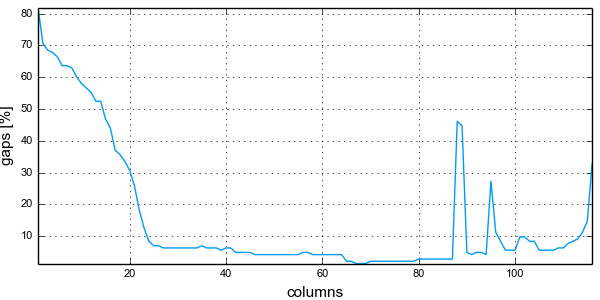

In [48]:
msa = read("http://pfam.xfam.org/family/PF09776/alignment/full", Stockholm)

using Plots

pyplot(size=(600,300))

plot(   1:ncolumns(msa), # x is a range from 1 to the number of columns
        columngapfraction(msa) .* 100.0, # y is a Vector{Float64} with the percentage of gaps of each column
        linetype = :line, 
        ylabel = "gaps [%]",
        xlabel = "columns",
        legend=false)


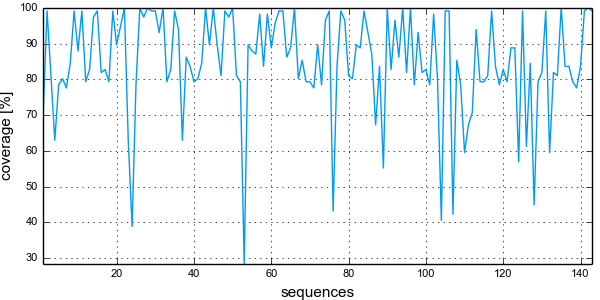

In [49]:
plot(   1:nsequences(msa), # x is a range from 1 to the number of sequences
        coverage(msa) .* 100, # y is a Vector{Float64} with the coverage of each sequence
        linetype = :line, 
        ylabel = "coverage [%]",
        xlabel = "sequences",
        legend=false)


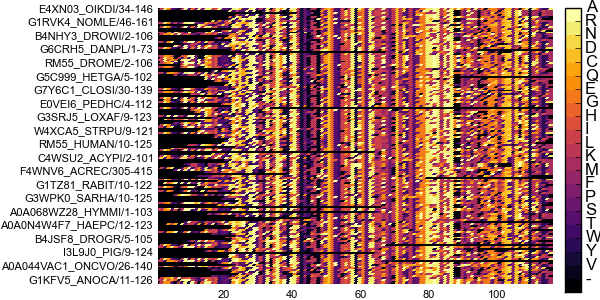

In [50]:
plot(msa)

<a href="#"><i class="fa fa-arrow-up"></i></a>

#### Example: Filter sequences per coverage and columns per gap fraction

Taking advantage of the `filter...!` functions and the `coverage` and `columngapfraction` functions, it’s possible to delete short sequences or columns with a lot of gaps. 


In [51]:
println("\tsequences\tcolumns")

println( "Before:\t", nsequences(msa), "\t\t", ncolumns(msa)  )

filtersequences!(msa, coverage(msa) .>= 0.9) # deletes sequences with less than 90% coverage of the MSA length 

filtercolumns!(msa, columngapfraction(msa) .<= 0.1) # deletes columns with more than 10% of gaps

println( "After:\t", nsequences(msa), "\t\t",  ncolumns(msa)  )

	sequences	columns
Before:	143		116
After:	50		110



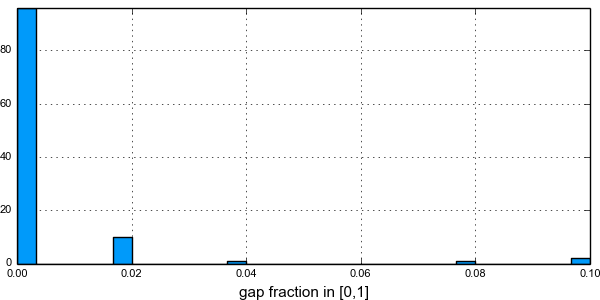

In [53]:
histogram(  columngapfraction(msa), # Vector{Float64} with the fraction of gaps of each column
xlabel = "gap fraction in [0,1]", legend=false) 


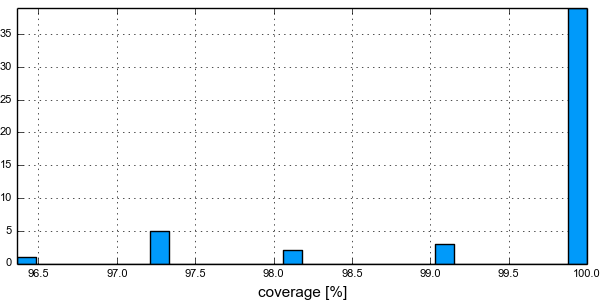

In [54]:
histogram(  coverage(msa) .* 100.0, #  Vector{Float64} with the coverage of each sequence
            xlabel = "coverage [%]", legend=false) 

<a href="#"><i class="fa fa-arrow-up"></i></a>

#### Example: Plotting the percentage of identity between sequences

The distribution of the percentage of identity between every pairs of sequences in a MSA, gives an idea of the MSA diversity. In this example, we are going to use `percentidentity` over a MSA to get that values.  

In [55]:
msa = read("http://pfam.xfam.org/family/PF09776/alignment/full", Stockholm)

pid = percentidentity(msa)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 39823  100 39823    0     0  31949      0  0:00:01  0:00:01 --:--:-- 31935


143x143 PairwiseListMatrices.PairwiseListMatrix{Float64,false}:
 100.0      22.6087   26.0417  …   20.6897   20.8696
  22.6087  100.0      33.913       73.2759   72.1739
  26.0417   33.913   100.0         34.4828   37.3913
  23.3333   21.7391   52.1277      23.2759   23.4783
  24.7312   33.0435   85.1064      33.6207   36.5217
   ⋮                           ⋱                    
  26.087    30.4348   45.7447      31.8966   31.3043
  22.2222   29.5652   30.6122      30.1724   31.3043
  20.8696   59.1304   40.0     …   54.3103   62.6087
  20.6897   73.2759   34.4828     100.0      70.6897
  20.8696   72.1739   37.3913      70.6897  100.0   

MIToS stores the matrix of percentage of identity between the aligned sequences as a PairwiseListMatrix
from the [PairwiseListMatrices<span class="fa fa-external-link" aria-hidden="true"></span>](#http://diegozea.github.io/PairwiseListMatrices.jl/) package. This matrix type saves RAM, allowing the storage of  big matrices. In this example, we use the `to_table` function of *PairwiseListMatrices* to convert the matrix into a table with indices.

In [56]:
pidtable = PairwiseListMatrices.to_table(pid, false)

10153x3 Array{Any,2}:
 "E4XN03_OIKDI/34-146"     "G1RVK4_NOMLE/46-161"  22.6087
 "E4XN03_OIKDI/34-146"     "B4NHY3_DROWI/2-106"   26.0417
 "E4XN03_OIKDI/34-146"     "G6CRH5_DANPL/1-73"    23.3333
 "E4XN03_OIKDI/34-146"     "RM55_DROME/2-106"     24.7312
 "E4XN03_OIKDI/34-146"     "G5C999_HETGA/5-102"   25.5319
 ⋮                                                       
 "A0A090MXF3_STRRB/2-104"  "RM55_MOUSE/9-124"     30.1724
 "A0A090MXF3_STRRB/2-104"  "M3XPJ7_MUSPF/10-125"  31.3043
 "G3WPK1_SARHA/11-126"     "RM55_MOUSE/9-124"     54.3103
 "G3WPK1_SARHA/11-126"     "M3XPJ7_MUSPF/10-125"  62.6087
 "RM55_MOUSE/9-124"        "M3XPJ7_MUSPF/10-125"  70.6897

The function `quantile` gives a quick idea of the percentage identity distribution of the MSA.  

In [57]:
quantile(convert(Vector{Float64}, pidtable[:,3]), [0.00, 0.25, 0.50, 0.75, 1.00])

5-element Array{Float64,1}:
   0.0   
  27.5862
  32.1739
  40.0   
 100.0   

The function `meanpercentidentity` gives the mean value of the percent identity distribution for MSA with less than 300 sequences, or a quick estimate (mean PID in a random sample of sequence pairs) otherwise unless you set `exact` to `true`.  

In [58]:
meanpercentidentity(msa)

35.639936765679174

One can easily plot that matrix and its distribution using the `heatmap` and `histogram` functions of the [Plots<span class="fa fa-external-link" aria-hidden="true"></span>](#https://github.com/tbreloff/Plots.jl) package.



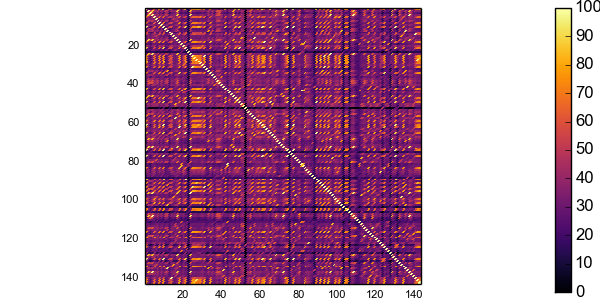

In [64]:
heatmap(full(pid), yflip=true, ratio=:equal)


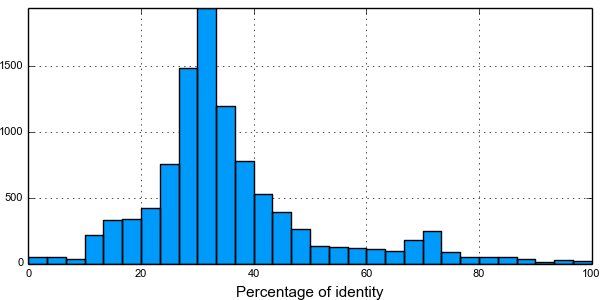

In [65]:
histogram(pidtable[:,3], xlabel ="Percentage of identity", legend=false)

<a href="#"><i class="fa fa-arrow-up"></i></a>

## Sequence clustering  

The `MSA` module allows to clusterize sequences in a MSA. The `hobohmI` function takes as input a MSA followed by an identity threshold value, and returns a `SequenceCluster` type with the result of a [Hobohm I<span class="fa fa-external-link" aria-hidden="true"></span>](#http://www.ncbi.nlm.nih.gov/pmc/articles/PMC2142204/) sequence clustering. The Hobohm I algorithm will add a sequence to an existing cluster, if the percentage of identity is equal or greater than the threshold.  
The `SequenceCluster` is sub-type of `ClusteringResult` from the [Clustering.jl<span class="fa fa-external-link" aria-hidden="true"></span>](#http://clusteringjl.readthedocs.org/en/latest/index.html) package. One advantage of use a sub-type of `ClusteringResult`is that you are able to use any method defined on `Clustering.jl` like `varinfo` (Variation of Information) for example. Also, you can use any clustering algorithm included in *Clustering.jl*, and convert its result to an `SequenceCluster` object to use them with MIToS.  
`MSA` defines the functions `nclusters` to get the resulting number of clusters, `counts` to get the number of sequences on each cluster and `assignments` to get the cluster number of each sequence. The most important method is `getweight`, which returns the weight of each sequence. This method is used in the `Information` module of MIToS to reduce redundancy.  

<a href="#"><i class="fa fa-arrow-up"></i></a>

#### Example: Reducing redundancy of a MSA

MSAs can suffer from an unnatural sequence redundancy and a high number of protein fragments. In this example, we will use a sequence clustering to make a non-redundant set of representative sequences using the function `hobohmI` to perform a clustering with the Hobohm I algorithm at 62% identity.  

In [81]:
msa = read("http://pfam.xfam.org/family/PF09776/alignment/full", Stockholm)

println("This MSA has ", nsequences(msa), " sequences...")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 39823  100 39823    0     0  31527      0  0:00:01  0:00:01 --:--:-- 31530


This MSA has 143 sequences...


In [82]:
clusters = hobohmI(msa, 62)

MIToS.MSA.SequenceClusters([1,39,14,2,1,1,1,1,6,1  …  1,3,1,1,1,2,1,1,1,1],[1,2,3,4,3,2,5,6,2,7  …  12,2,9,24,3,56,24,11,2,2],[1.0,0.025641,0.0714286,0.5,0.0714286,0.025641,1.0,1.0,0.025641,1.0  …  0.333333,0.025641,0.166667,0.25,0.0714286,1.0,0.25,0.333333,0.025641,0.025641])

In [83]:
println("...but has only ", nclusters(clusters), " sequence clusters after a clustering at 62% identity.")

...but has only 56 sequence clusters after a clustering at 62% identity.



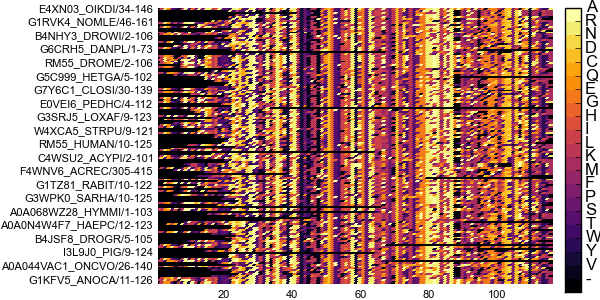

In [84]:
plot(msa)

We are going to use the [DataFrames<span class="fa fa-external-link" aria-hidden="true"></span>](#http://dataframesjl.readthedocs.org/en/latest/) package to easily select the sequence with highest coverage of each cluster.

In [85]:
using DataFrames

df = DataFrame( seqnum = 1:nsequences(msa),
                seqname = collect(names(msa)), 
                cluster = assignments(clusters), # the cluster number/index of each sequence
                coverage = coverage(msa))

,seqnum,seqname,cluster,coverage
1,1,E4XN03_OIKDI/34-146,1,0.7068965517241379
2,2,G1RVK4_NOMLE/46-161,2,0.9913793103448276
3,3,B4NHY3_DROWI/2-106,3,0.8103448275862069
4,4,G6CRH5_DANPL/1-73,4,0.6293103448275862
5,5,RM55_DROME/2-106,3,0.7844827586206896
6,6,G5C999_HETGA/5-102,2,0.8017241379310345
7,7,G7Y6C1_CLOSI/30-139,5,0.7758620689655172
8,8,E0VEI6_PEDHC/4-112,6,0.8448275862068966
9,9,G3SRJ5_LOXAF/9-123,2,0.9913793103448276
10,10,W4XCA5_STRPU/9-121,7,0.8793103448275862


It is possible to use this `DataFrame` and `Plots` to plot the sequence coverage of the MSA and also an histogram of the number of sequences in each cluster:  


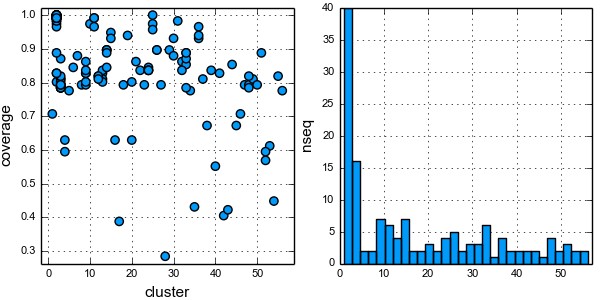

In [86]:
h = histogram(df[:cluster], ylabel="nseq")
p = plot(df, :cluster, :coverage, linetype=:scatter)
plot(p, h, nc=1, xlim=(0, nclusters(clusters)+1 ), legend=false)

We use the *Split-Apply-Combine* strategy, though the `by` function of the `DataFrames` package, to select the sequence of highest coverage for each cluster.  

In [87]:
maxcoverage = by(df, :cluster, cl -> cl[ findmax(cl[:coverage])[2] ,:])

,cluster,seqnum,seqname,cluster_1,coverage
1,1,1,E4XN03_OIKDI/34-146,1,0.7068965517241379
2,2,22,F7GI04_MACMU/7-122,2,1.0
3,3,56,Q177J1_AEDAE/3-112,3,0.8706896551724138
4,4,4,G6CRH5_DANPL/1-73,4,0.6293103448275862
5,5,7,G7Y6C1_CLOSI/30-139,5,0.7758620689655172
6,6,8,E0VEI6_PEDHC/4-112,6,0.8448275862068966
7,7,10,W4XCA5_STRPU/9-121,7,0.8793103448275862
8,8,12,C4WSU2_ACYPI/2-101,8,0.7931034482758621
9,9,93,E2AMM9_CAMFO/354-464,9,0.8620689655172413
10,10,14,G1TZ81_RABIT/10-122,10,0.9741379310344828



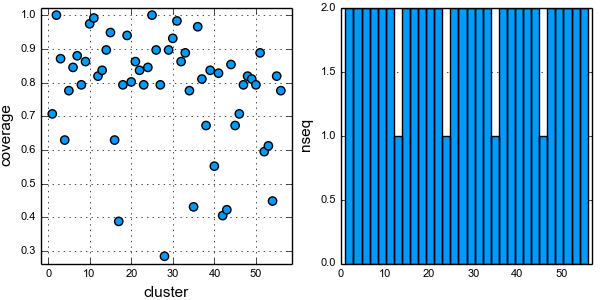

In [88]:
p = plot(maxcoverage, :cluster, :coverage, linetype=:scatter)
h = histogram(maxcoverage[:cluster], ylabel="nseq")
plot(p, h, nc=1, xlim=(0, nclusters(clusters)+1 ), legend=false)

We can easily generate a mask using list comprehension, to select only the representative sequences of the MSA (deleting the rest of the sequences with `filtersequences!`).

In [89]:
cluster_references = Bool[ seqnum in maxcoverage[:seqnum] for seqnum in 1:nsequences(msa) ]

143-element Array{Bool,1}:
  true
 false
 false
  true
 false
     ⋮
  true
 false
 false
 false
 false

In [90]:
filtersequences!(msa, cluster_references)

56x116 MIToS.MSA.AnnotatedMultipleSequenceAlignment:
 -  -  -  -  -  -  -  -  -  …  D  -  -  -  -  -  -  -  -
 -  -  -  -  -  -  -  -  -     K  K  Y  L  K  Y  L  K  K
 -  -  -  -  -  -  -  -  -     S  A  Y  E  F  L  -  -  -
 -  -  -  -  -  -  -  -  -     N  K  Y  L  N  L  L  K  K
 -  -  -  -  -  -  -  -  -     N  R  Y  K  H  L  W  N  K
 ⋮              ⋮           ⋱           ⋮              ⋮
 -  -  -  -  -  -  -  -  -     E  R  Y  R  Q  F  W  T  R
 -  -  -  -  -  -  -  -  -     R  S  W  T  R  L  I  K  K
 L  L  W  Q  C  G  M  T  R     -  -  -  -  -  -  -  -  -
 -  -  -  -  -  -  -  -  -     R  K  Y  L  K  Y  I  K  -
 -  -  -  -  -  -  -  -  -  …  N  K  Y  S  Y  L  W  K  K


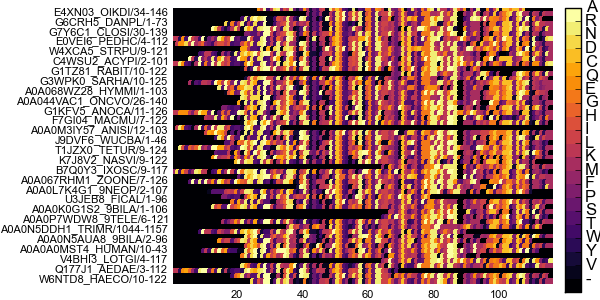

In [91]:
plot(msa)

<a href="#"><i class="fa fa-arrow-up"></i></a>